In [549]:
from pymongo import MongoClient
import pandas as pd
import seaborn as sns

In [550]:
client = MongoClient()
db = client.amensch

In [551]:
# Normal model

In [552]:
runs = db.multi_predict_contrast_trace

multi_dataset_res = runs.aggregate([{"$match": {"info.multi_predict_contrast_id": {"$in": [363]}
                                               }},
                                    {'$project': {'penalty': '$config.penalty',
                                                  'alpha': '$config.alpha',
                                                  'seed': '$config.seed',
                                                  'multi_class': '$config.multi_class',
                                                  'test_score': '$info.test_archi_score',
                                                  'train_score': '$info.train_archi_score',
                                                  "datasets": "$config.datasets"}}])

multi_dataset_res = list(multi_dataset_res)
df = pd.DataFrame(multi_dataset_res)
# df = df.loc[df['penalty'] == 'trace']
df['datasets'] = df['datasets'].map(lambda x: '_'.join(x) if isinstance(x, list) else x)
df = df.set_index(['datasets', 'alpha', 'penalty', 'multi_class', 'seed'])
df.sort_index(inplace=True)

df_agg = df.groupby(level=['datasets', 'alpha', 'penalty', 'multi_class']).aggregate(['mean', 'std'])['test_score']

nf_score_without_transfer =  df_agg.loc[df_agg.loc[idx['archi', :, :, :], 'mean'].argmax()]
nf_score_with_transfer =  df_agg.loc[df_agg.loc[idx['archi_hcp', :, :, :], 'mean'].argmax()]

idx = pd.IndexSlice
nf_trace_score_without_transfer =  df_agg.loc[df_agg.loc[idx['archi', :, 'trace', :], 'mean'].argmax()]
nf_trace_score_with_transfer =  df_agg.loc[df_agg.loc[idx['archi_hcp', :, 'trace', :], 'mean'].argmax()]

In [553]:
arg_sum_df = df_agg['mean'].groupby(level=['penalty', 'datasets']).agg('idxmax')
nf_sum_df = pd.DataFrame(index=arg_sum_df.index, data=df_agg.loc[arg_sum_df].values, columns=['mean', 'std'])

In [554]:
# Per fold gain

In [555]:
per_fold = (df.loc[arg_sum_df.loc[('l2', 'archi_hcp')]] - df.loc[arg_sum_df.loc[('l2', 'archi')]])['test_score']
per_fold.describe()

count    10.000000
mean      0.006923
std       0.002187
min       0.003419
25%       0.005983
50%       0.006838
75%       0.008333
max       0.010256
Name: test_score, dtype: float64

In [556]:
print('Average per fold improvement: %.3f +- %.3f' % (per_fold_gain, per_fold_std))

Average per fold improvement: 0.007 +- 0.002


In [557]:
# Factored model

In [558]:
runs = db.multi_predict_contrast
multi_dataset_res = runs.aggregate([{"$match": {"info.multi_predict_contrast_id": 2265
                                               }},
                                    {'$project': {'beta': '$config.beta',
                                                  'dropout': '$config.dropout',
                                                  'latent_dim': '$config.latent_dim',
                                                  'activation': '$config.activation',
                                                  'alpha': '$config.alpha',
                                                  'seed': '$config.seed',
                                                  'test_score': '$info.test_archi_score',
                                                  'train_score': '$info.train_archi_score',
                                                  'test_hcp_score': '$info.test_hcp_score',
                                                  'train_hcp_score': '$info.train_hcp_score',
                                                  "datasets": "$config.datasets"}}])

multi_dataset_res = list(multi_dataset_res)
df = pd.DataFrame(multi_dataset_res)
df['datasets'] = df['datasets'].map(lambda x: '_'.join(x) if isinstance(x, list) else x)
# df = df.loc[np.logical_not(df['dropout'])]
df = df.set_index(['datasets', 'alpha', 'beta', 'dropout', 'activation', 'latent_dim', 'seed'])
df.sort_index(inplace=True)


df_agg = df.groupby(level=['datasets', 'alpha', 'beta', 'dropout', 'activation', 'latent_dim']).aggregate(['mean', 'std'])['test_score']

f_score_without_transfer = {}
f_score_with_transfer = {}
for (dropout, latent_dim), this_df in df_agg.groupby(level=['dropout', 'latent_dim']):
    f_score_without_transfer[dropout, latent_dim] =  df_agg.loc[this_df.loc[idx['archi', :, :, :], 'mean'].argmax()]
    f_score_with_transfer[dropout, latent_dim] =  df_agg.loc[this_df.loc[idx['archi_hcp', :, :, :], 'mean'].argmax()]

In [559]:
arg_sum_df = df_agg['mean'].groupby(level=['latent_dim', 'dropout', 'datasets']).agg('idxmax')

f_sum_df = pd.DataFrame(index=arg_sum_df.index, data=df_agg.loc[arg_sum_df].values, columns=['mean', 'std'])

In [560]:
import seaborn as sns

In [561]:
def errorbar(x, y, std, **kws):
    plt.errorbar((np.arange(len(y)) - .5) / 2, y, std, color='black', elinewidth=2, linewidth=0)

In [562]:
data = f_sum_df.reset_index()
g = sns.factorplot(x="dropout", y="mean", hue="datasets", data=data,
                   col='latent_dim',
                   size=3, kind="bar", palette="muted")
g.map(errorbar, 'latent_dim', 'mean', 'std')
for ax in np.ravel(g.axes):
    ax.set_ylim([0.7, 0.9])

In [563]:
data = nf_sum_df.reset_index()
g = sns.factorplot(x="penalty", y="mean", hue="datasets", data=data,
                   size=3, kind="bar", palette="muted")
g.map(errorbar, 'penalty', 'mean', 'std')
for ax in np.ravel(g.axes):
    ax.set_ylim([0.7, 0.9])

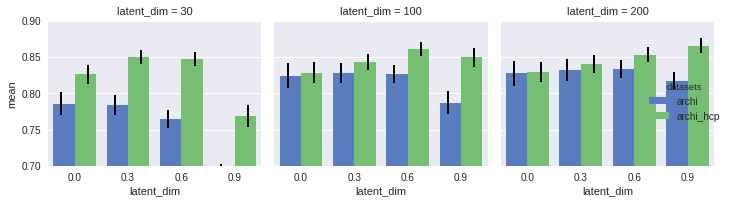

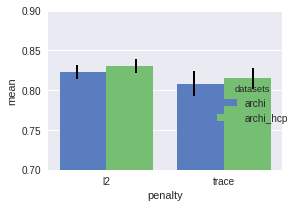

In [564]:
plt.show()

In [516]:
arg_sum_df

latent_dim  dropout  datasets 
30          0.0      archi              (archi, 1e-05, 0.0001, 0.0, linear, 30)
                     archi_hcp         (archi_hcp, 0.001, 0.0, 0.0, linear, 30)
            0.3      archi                 (archi, 1e-06, 0.0, 0.3, linear, 30)
                     archi_hcp     (archi_hcp, 0.0001, 0.0001, 0.3, linear, 30)
            0.6      archi               (archi, 1e-06, 1e-05, 0.6, linear, 30)
                     archi_hcp     (archi_hcp, 0.0001, 0.0001, 0.6, linear, 30)
            0.9      archi               (archi, 1e-06, 1e-06, 0.9, linear, 30)
                     archi_hcp     (archi_hcp, 0.0001, 0.0001, 0.9, linear, 30)
100         0.0      archi             (archi, 1e-05, 0.0001, 0.0, linear, 100)
                     archi_hcp     (archi_hcp, 0.001, 0.0001, 0.0, linear, 100)
            0.3      archi              (archi, 1e-06, 1e-05, 0.3, linear, 100)
                     archi_hcp    (archi_hcp, 0.0001, 0.0001, 0.3, linear, 100)
         

In [539]:
arg_sum_df.loc[idx[:, :, 'archi_hcp']]

latent_dim  dropout
30          0.0             (archi_hcp, 0.001, 0.0, 0.0, linear, 30)
            0.3         (archi_hcp, 0.0001, 0.0001, 0.3, linear, 30)
            0.6         (archi_hcp, 0.0001, 0.0001, 0.6, linear, 30)
            0.9         (archi_hcp, 0.0001, 0.0001, 0.9, linear, 30)
100         0.0         (archi_hcp, 0.001, 0.0001, 0.0, linear, 100)
            0.3        (archi_hcp, 0.0001, 0.0001, 0.3, linear, 100)
            0.6         (archi_hcp, 1e-05, 0.0001, 0.6, linear, 100)
            0.9         (archi_hcp, 0.0001, 1e-06, 0.9, linear, 100)
200         0.0         (archi_hcp, 0.001, 0.0001, 0.0, linear, 200)
            0.3        (archi_hcp, 0.0001, 0.0001, 0.3, linear, 200)
            0.6         (archi_hcp, 1e-05, 0.0001, 0.6, linear, 200)
            0.9         (archi_hcp, 1e-05, 0.0001, 0.9, linear, 200)
Name: mean, dtype: object

In [548]:
for indices in arg_sum_df.index.values[::2]:
    diff = df.loc[arg_sum_df.loc[idx[:, :, 'archi_hcp']].loc[indices[:2]]] - df.loc[arg_sum_df.loc[idx[:, :, 'archi']].loc[indices[:2]]]
    mean = diff['test_score'].mean()
    print(indices[:2], mean)

(30, 0.0) 0.0401709401709
(30, 0.3) 0.0663247863248
(30, 0.6) 0.082735042735
(30, 0.9) 0.0799145299145
(100, 0.0) 0.00435897435897
(100, 0.3) 0.0153846153846
(100, 0.6) 0.0345299145299
(100, 0.9) 0.0623931623932
(200, 0.0) 0.00128205128205
(200, 0.3) 0.00897435897436
(200, 0.6) 0.0199145299145
(200, 0.9) 0.0479487179487


In [541]:
arg_sum_df.index.values

array([(30, 0.0, 'archi'), (30, 0.0, 'archi_hcp'), (30, 0.3, 'archi'),
       (30, 0.3, 'archi_hcp'), (30, 0.6, 'archi'), (30, 0.6, 'archi_hcp'),
       (30, 0.9, 'archi'), (30, 0.9, 'archi_hcp'), (100, 0.0, 'archi'),
       (100, 0.0, 'archi_hcp'), (100, 0.3, 'archi'),
       (100, 0.3, 'archi_hcp'), (100, 0.6, 'archi'),
       (100, 0.6, 'archi_hcp'), (100, 0.9, 'archi'),
       (100, 0.9, 'archi_hcp'), (200, 0.0, 'archi'),
       (200, 0.0, 'archi_hcp'), (200, 0.3, 'archi'),
       (200, 0.3, 'archi_hcp'), (200, 0.6, 'archi'),
       (200, 0.6, 'archi_hcp'), (200, 0.9, 'archi'),
       (200, 0.9, 'archi_hcp')], dtype=object)